# Topometric registration full version

This notebook presents a short demo of running topometric registration on the Devens pickle file using Ceres solver as a backend optimizer.

In [1]:
import gc
import _pickle as pkl
import matplotlib.pyplot as plt
import shapely.geometry as geo
import numpy as np
import networkx as nx
import os
import pandas as pd
from scipy.optimize import minimize
import subprocess
import sys

In [57]:
# Set all file paths here

# Current dir
# dirname = os.path.dirname(__file__)
basedir = '/home/jatavalk/code/TopometricRegistration/notebooks/'
datadir = '/home/jatavalk/data/devens/chunks/'

# Input OpenStreetMap (OSM)
osm_nodes_file = os.path.join(basedir, '../devensData/devens_osm/osm_nodes.txt')
osm_edges_file = os.path.join(basedir, '../devensData/devens_osm/osm_edges.txt')

# Directory to store plots at
plot_dir = os.path.join(basedir, '../cache')

# Pickle file containing annotated scans
pickle_scan_file = os.path.join(datadir, 'scans_in_utm_annotated_000050_000100.pkl')

# Path to ground-truth OSM (for accuracy evaluation)
osm_gt_nodes_file = os.path.join(basedir, '../devensData/devens_osm/osm_nodes_truth.txt')
osm_gt_edges_file = os.path.join(basedir, '../devensData/devens_osm/osm_edges_truth.txt')

# Devens map (for reference sake, and for visualization; stored as a shapeley polygon)
devens_map_file = os.path.join(basedir, '../devensData/devens_map/devens_map_poly.pkl')

# Ceres solver paths
ceres_build_dir = '/home/jatavalk/code/TopometricRegistration/ceresCode/build/'
ceres_input_dir = '/home/jatavalk/code/TopometricRegistration/ceresCode/data/'
ceres_command = ceres_build_dir + 'topometricRegistration'

In [58]:
# All important hyperparameters are set here

# Random seed
randomseed = 1234

# Threshold distance within which OSM nodes are retained
osm_thresh = 5.

# Translational noise in OSM perturbation (along the X and Y directions)
trans_noise = 5.
# Rotational noise in OSM perturbation (about the Z-axis) (degrees-to-radians)
rot_noise = np.deg2rad(10.)

# Neighborhood distance to consider when associating OSM nodes to road points
nbd = 3.

# Number of scan points to skip (it's tedious to process all of them, so we add constraints to only a few points)
scan_points_to_skip = 10

In [59]:
# Load data in

# OSM
osm_nodes = np.genfromtxt(osm_nodes_file, delimiter = ',')
osm_edges = np.genfromtxt(osm_edges_file, delimiter = ',', dtype = int)

# Create a graph of the osm nodes and edges
osm_graph = nx.Graph()
osm_graph.add_nodes_from(range(len(osm_nodes)))
osm_graph.add_edges_from(osm_edges)

# OSM Ground-truth
osm_gt_nodes = np.genfromtxt(osm_gt_nodes_file, delimiter = ',')
osm_gt_edges = np.genfromtxt(osm_gt_edges_file, delimiter = ',', dtype = int)

# Annotated Velodyne scans in UTM frame
all_scans = pd.read_pickle(pickle_scan_file)
# # Throw away latitude, longitude information
# all_scans = all_scans.loc[:,'theta':]

### Helper functions
Functions to help add noise to an OSM/scan (i.e., rotate/translate/both, etc.).

In [93]:
# Construct a 2D rotation matrix, given theta (in radians)
def rot2D(theta):
    return np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])


# Function to rotate a point by a fixed angle theta
def rotate_points(points, theta):
    # Assumes that points is an N-by-2 numpy array
    if points.shape[1] != 2:
        points = points.T
    # Get a rotation matrix (2D)
    R = rot2D(theta)
    
    # Function to rotate a single point
    # Had do be defined inside "rotate_points", because np.apply_over_axes does not support functions with
    # multiple arguments. Has the "rotate_single_point" function been defined oustide this function, it would've 
    # to include "R" as an additional argument
    def rotate_single_point(point, axis):
        return np.matmul(R, point.T)
    
    # Apply "rotate_single_point" over all points
    points = np.apply_over_axes(rotate_single_point, points, axes=[0]).T
    return points


# Function to translate a point set by a fixed translation vector t
def translate_points(points, t):
    # Assumes that points is an N-by-2 numpy array
    if points.shape[1] != 2:
        points = points.T
    # Assumes that t is a 1-by-2 vector
    if t.shape != (1,2):
        if t.shape == (2,1):
            t = t.T
        else:
            raise ValueError('t should be either a 1-by-2 or a 2-by-1 vector')
    return points + t


# Function to rotate and translate a point set by a fixed angle theta and a fixed translation vector t
def rotate_and_translate_points(points, theta, t):
    return translate_points(rotate_points(points, theta), t)

[[0.29289322 3.12132034]
 [0.29289322 4.53553391]
 [0.29289322 5.94974747]]


### Main processing loop

Iterate over all scans in the current pickle file, perturb the OSM nodes around the location, and perform *TopometricRegistration* on the perturbed OSM. Then, visualize the initial vs optimized OSMs, and also compute error metrics wrt the ground-truth OSM.

50 scans loaded ...
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9] [(0, 2), (1, 5), (1, 9), (2, 7), (3, 7), (3, 8), (4, 7), (5, 7), (6, 8)]


/home/jatavalk/.local/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


Rot error: 1.3273611158390342
Trans error: [[0.45942313 8.11304962]]


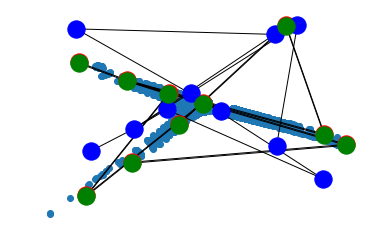

In [94]:
# Seed RNG, for repeatability
# np.random.seed(randomseed)

print(str(len(all_scans.index)) + ' scans loaded ...')
for scanidx in range(1):
    # Point cloud in UTM frame
    scan = all_scans.iloc[scanidx]['scan_utm']
    # Get indices of road points
    road_indices = all_scans.iloc[scanidx]['is_road_truth']
    road_indices = np.where(road_indices)
    # Get indices of non-NaN points
    non_nan_indices = np.logical_not(all_scans.iloc[scanidx]['nan'])
    non_nan_indices = np.where(non_nan_indices)
    # Get indices of non-NaN "road" points
    active_indices = np.intersect1d(road_indices, non_nan_indices)
    scan_active = scan[active_indices]
    scan_active = np.asarray([[item[0] for item in scan_active], [item[1] for item in scan_active], [item[2] for item in scan_active]]).T
    # print(scan_active.shape)
    
    # Compute a bounding rectangle around the active scan points
    xmin, ymin = scan_active.min(0)[0], scan_active.min(0)[0]
    xmax, ymax = scan_active.max(0)[0], scan_active.max(0)[0]
    
    # We only care about OSM nodes that lie within a threshold distance of the sensor swath (scan boundaries)
    xinds = np.where(np.logical_and(osm_nodes[:,0] > xmin - osm_thresh, osm_nodes[:,0] < xmax + osm_thresh))
    yinds = np.where(np.logical_and(osm_nodes[:,1] > ymin - osm_thresh, osm_nodes[:,1] < ymax + osm_thresh))
    osm_inds = np.intersect1d(xinds, yinds)
    # print(osm_inds)
    osm_active = osm_nodes[osm_inds]
    osm_subgraph = osm_graph.subgraph(osm_inds)
    osm_subgraph = nx.convert_node_labels_to_integers(osm_subgraph)
    print(osm_subgraph.nodes(), osm_subgraph.edges())
    
    # Perturb the initial OSM (to simulate error)
    trans_error = np.random.normal([0., 0.], [trans_noise, trans_noise], [1, 2])
    rot_error = np.random.normal(rot_noise)
    print('Rot error:', rot_error)
    print('Trans error:', trans_error)
    # osm_perturbed = osm_active + trans_error
    osm_perturbed = rotate_and_translate_points(osm_active, rot_error, trans_error)
    
    # Create input files for Ceres: Write OSM to file
    ceres_input_file_osm = os.path.join(ceres_input_dir, 'osm_nodes_noisy.txt')
    infile_osm = open(ceres_input_file_osm, 'w')
    infile_osm.write(str(osm_active.shape[0]) + '\n')
    for nodeidx in range(osm_active.shape[0]):
        infile_osm.write(str(osm_active[nodeidx,0]) + ' ' + str(osm_active[nodeidx,1]) + '\n')
    infile_osm.close()
    
    # Create input files for Ceres: Write scan points to file
    ceres_input_file_constraints = os.path.join(ceres_input_dir, 'constraints.txt')
    # For each OSM node, get scan points in a bounding box of threshold distance
    infile_constraints = open(ceres_input_file_constraints, 'w')
    infile_constraints.write('{}\n'.format(osm_active.shape[0]))
    num_constraints = []
    out_str = ''
    for nodeidx in range(osm_active.shape[0]):
        x_cur, y_cur = osm_active[nodeidx,0], osm_active[nodeidx,1]
        cur_xinds = np.where(np.logical_and(scan_active[:,0] > x_cur - nbd, scan_active[:,0] < x_cur + nbd))
        cur_yinds = np.where(np.logical_and(scan_active[:,1] > y_cur - nbd, scan_active[:,1] < y_cur + nbd))
        cur_inds = np.intersect1d(cur_xinds, cur_yinds)
        neighbors = scan_active[cur_inds,:]
        
        # # Visualize this neighborhood sampling
        # plt.scatter(scan_active[:,0], scan_active[:,1])
        # plt.scatter(x_cur, y_cur)
        # plt.scatter([x_cur-nbd, x_cur-nbd, x_cur+nbd, x_cur+nbd], [y_cur-nbd, y_cur+nbd, y_cur-nbd, y_cur+nbd])
        # plt.scatter(scan_active[cur_inds,0], scan_active[cur_inds,1])
        
        # Write the constraints to file
        num_constraints.append(neighbors.shape[0])
        # infile_constraints.write('{}\n'.format(neighbors.shape[0]))
        for n in neighbors:
            out_str += '{} {}\n'.format(n[0], n[1])
            # infile_constraints.write('{} {}\n'.format(n[0], n[1]))
    for n in num_constraints:
        infile_constraints.write('{} '.format(n))
    infile_constraints.write('\n')
    infile_constraints.write(out_str)
            
    infile_constraints.close()
    
    # Run the optimizer
    subprocess.call(ceres_command)
    
    # Read in the results
    ceres_output_file = os.path.join(ceres_input_dir, 'output.txt')
    osm_nodes_optimized = np.copy(osm_active)
    outfile = open(ceres_output_file)
    lines = outfile.readlines()
    j = 0
    for line in lines:
        if j == 0:
            j += 1
            continue
        line = line.strip().split()
        osm_nodes_optimized[j-1,0] = line[0]
        osm_nodes_optimized[j-1,1] = line[1]
        j += 1
    outfile.close()
    
    # Visualize scan points and OSM
    plt.scatter(scan_active[:,0], scan_active[:,1])
    plt.scatter(osm_active[:,0], osm_active[:,1])
    nx.draw(osm_subgraph, pos = osm_active)
    nx.draw(osm_subgraph, pos = osm_perturbed, node_color='b')
    nx.draw(osm_subgraph, pos = osm_nodes_optimized, node_color='g')
    
    